In [3]:
from datasets.shapenet_part import PartNormalDataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from datasets.shapenet_data_pc import ShapeNet15kPointClouds

from metrics.ChamferDistancePytorch.chamfer_python import distChamfer

from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud
from models_adl4cv.pvcnn import PVCNNPartSeg, PVCNN

In [4]:
tr_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

val_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["airplane"], split='val',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

test_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["airplane"], split='test',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:2832
Min number of points: (train)2048 (test)2048
Total number of data:405
Min number of points: (train)2048 (test)2048
Total number of data:808
Min number of points: (train)2048 (test)2048


In [5]:
len(tr_dataset), len(val_dataset), len(test_dataset)

(2832, 405, 808)

In [6]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

In [7]:
def add_random_noise(point_cloud, mean=0, std=0.025):
    noise = torch.normal(mean, std, size=point_cloud.size()).to("cuda")
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

In [8]:
def chamfer_distance(a, b):
    min_dist_a_to_b, min_dist_b_to_a, _, _ = distChamfer(a, b)
    return (min_dist_a_to_b.mean() + min_dist_b_to_a.mean()) / 2

In [9]:
model = PVCNN(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")

In [10]:
part_model = PVCNNPartSeg(num_classes=4, num_shapes=3, extra_feature_channels=0).to("cuda")
part_model.load_state_dict(torch.load("output-models/pvcnn-part-segmentation-noise/PVCNN-Part-Segmentation-Noise-e69.pth"))

<All keys matched successfully>

In [11]:
for batch in train_dataloader:
    input = batch["train_points"].to("cuda")
    break

In [12]:
input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1]
input_seg.shape

torch.Size([20, 2048])

In [13]:
output_batch = []
for (sample, seg) in zip(input, input_seg):
    # print(sample.shape, seg.shape, seg.max())

    output_tensor = torch.zeros_like(sample)
    for i in range(seg.max() + 1):
        part_input = sample[seg==i, :]

        # If the segmeneted part has less than 64 points we don't refine it.
        if part_input.shape[0] < 64:
            output_tensor[seg==i, :] = sample[seg==i, :]
            continue
        
        output = model(part_input.unsqueeze(0).transpose(1,2))
        output_tensor[seg==i, :] = output.squeeze().transpose(0,1)

    output_batch.append(output_tensor.unsqueeze(0))

In [14]:
torch.all(output_tensor == sample)

tensor(False, device='cuda:0')

In [15]:
torch.cat(output_batch).shape, input.shape

(torch.Size([20, 2048, 3]), torch.Size([20, 2048, 3]))

In [16]:
# TensorBoard Logging with model's name and current date
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PVCNN-Refinement-Part'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

# Optimization
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

# Losses
training_losses = []
val_losses = []

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

In [17]:
# TODO: Maybe it would be better if we first add noise and then segment the input
# TODO: Evaluate this approach too, it will most likely be better.

# Time to train
for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0

    # Train
    model.train()
    for batch in train_dataloader:
        input = batch["train_points"].to("cuda")
        
        noised_input = add_random_noise(input)
        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1]

        optimizer.zero_grad()
        # Now we have to unfortunately sequentially go through each part.
        # Add noise to it and refine it. (Different part sizes...)
        output_batch = []
        for (sample, sample_noised, seg) in zip(input, noised_input, input_seg):
            output_tensor = torch.zeros_like(sample)
            
            for i in range(seg.max() + 1):
                part_input = sample_noised[seg==i, :]

                # If the segmeneted part has less than 64 points we don't refine it.
                if part_input.shape[0] < 64:
                    output_tensor[seg==i, :] = sample[seg==i, :]
                    continue

                output = model(part_input.unsqueeze(0).transpose(1,2))
                output_tensor[seg==i, :] = output.squeeze().transpose(0,1)

            output_batch.append(output_tensor.unsqueeze(0))
        
        output_batch = torch.cat(output_batch)
        
        loss = chamfer_distance(input, output_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)

    # Epoch is done; Reduce LR
    lr_scheduler.step()

    # Validate
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            input = batch["train_points"].to("cuda")
            
            # Let's first add noise
            noised_input = add_random_noise(input)

            # Let's segment the input into parts and extract the part assignment.
            input_seg = part_model(noised_input.transpose(1,2)).transpose(1,2).data.max(2)[1]
            
            output_batch = []
            for (sample, sample_noised, seg) in zip(input, noised_input, input_seg):
                output_tensor = torch.zeros_like(sample)
                
                for i in range(seg.max() + 1):
                    part_input = sample_noised[seg==i, :]

                    # If the segmeneted part has less than 64 points we don't refine it.
                    if part_input.shape[0] < 64:
                        output_tensor[seg==i, :] = sample[seg==i, :]
                        continue

                    output = model(part_input.unsqueeze(0).transpose(1,2))
                    output_tensor[seg==i, :] = output.squeeze().transpose(0,1)

                output_batch.append(output_tensor.unsqueeze(0))
            
            output_batch = torch.cat(output_batch)

            val_loss = chamfer_distance(input, output_batch)
            total_val_loss += val_loss.item()

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)

    print(f"Epoch {epoch+1},  Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0  # reset the patience counter
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    # Break the loop if patience exceeded
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    # Save the model
    model_save_path = f"output-models/pvcnn-refinement-part/PVCNN-Baseline-Refinement-Part-e{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)


writer.close()

Epoch 1,  Training Loss: 0.0594, Validation Loss: 0.0555
Epoch 2,  Training Loss: 0.0264, Validation Loss: 0.0435
Epoch 3,  Training Loss: 0.0204, Validation Loss: 0.0313
Epoch 4,  Training Loss: 0.0160, Validation Loss: 0.0245
Epoch 5,  Training Loss: 0.0134, Validation Loss: 0.0226
Epoch 6,  Training Loss: 0.0119, Validation Loss: 0.0259
No improvement in validation loss for 1 epochs.
Epoch 7,  Training Loss: 0.0108, Validation Loss: 0.0262
No improvement in validation loss for 2 epochs.
Epoch 8,  Training Loss: 0.0100, Validation Loss: 0.0248
No improvement in validation loss for 3 epochs.
Epoch 9,  Training Loss: 0.0094, Validation Loss: 0.0261
No improvement in validation loss for 4 epochs.
Epoch 10,  Training Loss: 0.0090, Validation Loss: 0.0249
No improvement in validation loss for 5 epochs.
Epoch 11,  Training Loss: 0.0087, Validation Loss: 0.0249
No improvement in validation loss for 6 epochs.
Epoch 12,  Training Loss: 0.0084, Validation Loss: 0.0284
No improvement in validat

In [10]:
import pandas as pd

df_train = pd.read_csv("./eval-results/pvcnn-refinement-part-run-train-loss.csv")
df_val = pd.read_csv("./eval-results/pvcnn-refinement-part-run-val-loss.csv")

training_losses = df_train["Value"].to_numpy()
val_losses = df_val["Value"].to_numpy()

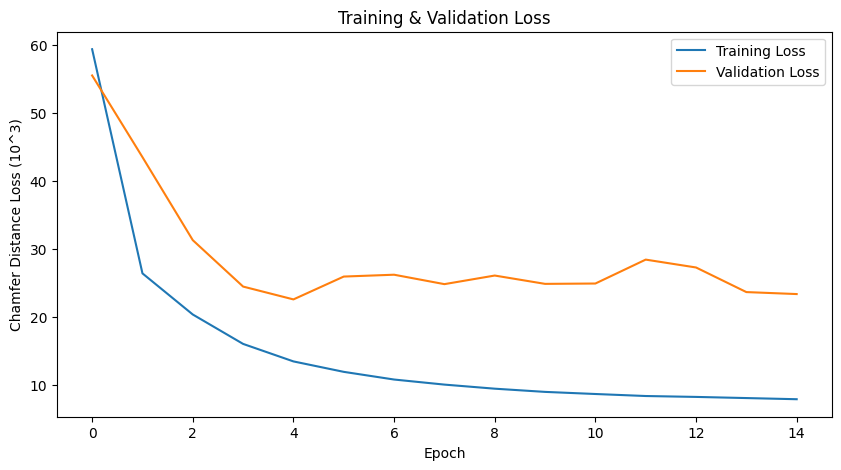

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(training_losses) * (10**3), label='Training Loss')
plt.plot(np.array(val_losses) * (10**3), label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Chamfer Distance Loss (10^3)')
plt.legend()
plt.show()

In [20]:
print(f"Best Train Loss: Epoch: {np.argmin(training_losses)}, Loss: {np.min(training_losses)* (10**3):.4f}")
print(f"Best Val Loss: Epoch: {np.argmin(val_losses)}, Loss: {np.min(val_losses) * (10**3):.4f}")

Best Train Loss: Epoch: 14, Loss: 7.8857
Best Val Loss: Epoch: 4, Loss: 22.5718


In [57]:
model = PVCNN(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")
model.load_state_dict(torch.load(f"output-models/pvcnn-refinement-part/PVCNN-Baseline-Refinement-Part-e{np.argmax(val_losses)+1}.pth"))

<All keys matched successfully>

In [58]:
 # Test
total_test_loss = 0
batch_i=1
model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        input = batch["test_points"].to("cuda")
        
        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1]
        
        output_batch = []
        for (sample, seg) in zip(input, input_seg):
            output_tensor = torch.zeros_like(sample)

            for i in range(seg.max() + 1):
                part_input = sample[seg==i, :]

                # If the segmeneted part has less than 64 points we don't refine it.
                if part_input.shape[0] < 64:
                    output_tensor[seg==i, :] = sample[seg==i, :]
                    continue
                
                part_input_noise = add_random_noise(part_input)

                output = model(part_input_noise.unsqueeze(0).transpose(1,2))
                output_tensor[seg==i, :] = output.squeeze().transpose(0,1)

            output_batch.append(output_tensor.unsqueeze(0))
        
        output_batch = torch.cat(output_batch)

        print(input.shape, output_batch.shape)
        test_loss = chamfer_distance(input, output_batch)
        total_test_loss += test_loss.item()
        print(f"Batch: {batch_i}; CD Loss: {test_loss.item() * 10**3:.4f}")
        batch_i+=1

avg_total_loss = total_test_loss / len(test_dataloader)
print(f"Test Loss: {avg_total_loss * 10**3:.4f}")

torch.Size([20, 2048, 3]) torch.Size([20, 2048, 3])
Batch: 1; CD Loss: 89.2039
torch.Size([20, 2048, 3]) torch.Size([20, 2048, 3])
Batch: 2; CD Loss: 112.3291
torch.Size([20, 2048, 3]) torch.Size([20, 2048, 3])
Batch: 3; CD Loss: 123.1365
torch.Size([20, 2048, 3]) torch.Size([20, 2048, 3])
Batch: 4; CD Loss: 84.6635
torch.Size([20, 2048, 3]) torch.Size([20, 2048, 3])
Batch: 5; CD Loss: 95.1798
torch.Size([20, 2048, 3]) torch.Size([20, 2048, 3])
Batch: 6; CD Loss: 130.6809
torch.Size([20, 2048, 3]) torch.Size([20, 2048, 3])
Batch: 7; CD Loss: 101.3489
torch.Size([20, 2048, 3]) torch.Size([20, 2048, 3])
Batch: 8; CD Loss: 101.9892
torch.Size([20, 2048, 3]) torch.Size([20, 2048, 3])
Batch: 9; CD Loss: 114.0767
torch.Size([20, 2048, 3]) torch.Size([20, 2048, 3])
Batch: 10; CD Loss: 82.2587
torch.Size([20, 2048, 3]) torch.Size([20, 2048, 3])
Batch: 11; CD Loss: 97.6278
torch.Size([20, 2048, 3]) torch.Size([20, 2048, 3])
Batch: 12; CD Loss: 98.3071
torch.Size([20, 2048, 3]) torch.Size([20, 2

In [59]:
INDEX = 4
input_pc = input[INDEX, ...].detach().cpu().numpy()
output_pc = output_batch[INDEX, ...].detach().cpu().numpy()
input_pc.shape, output_pc.shape

((2048, 3), (2048, 3))

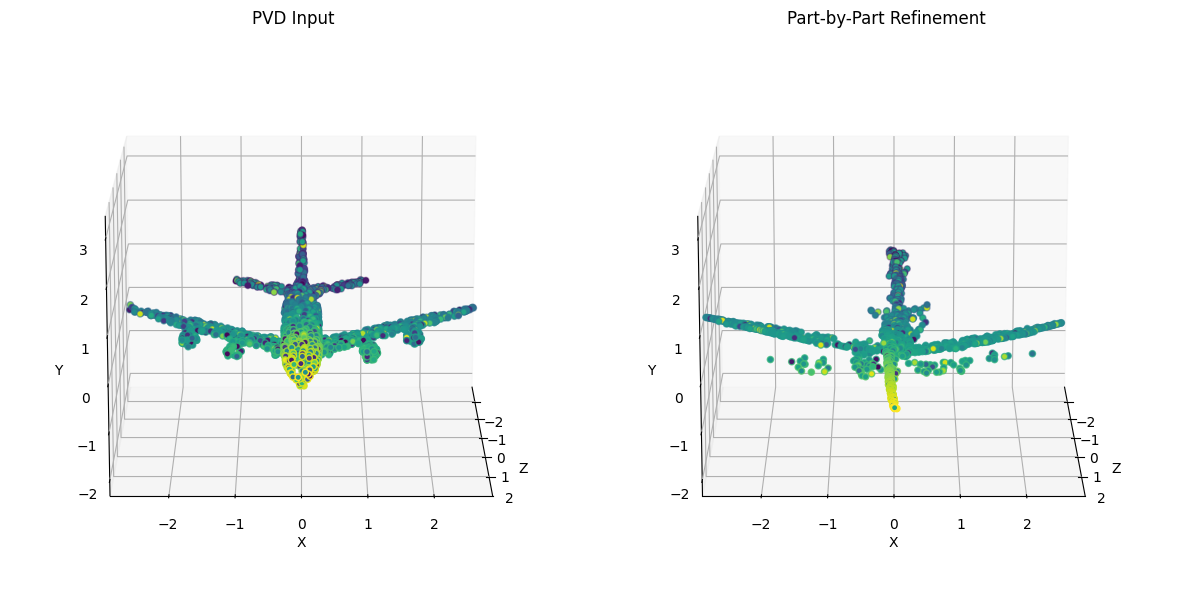

In [60]:
fig = visualize_pointcloud_eval(input_pc, output_pc, "PVD Input", "Part-by-Part Refinement")

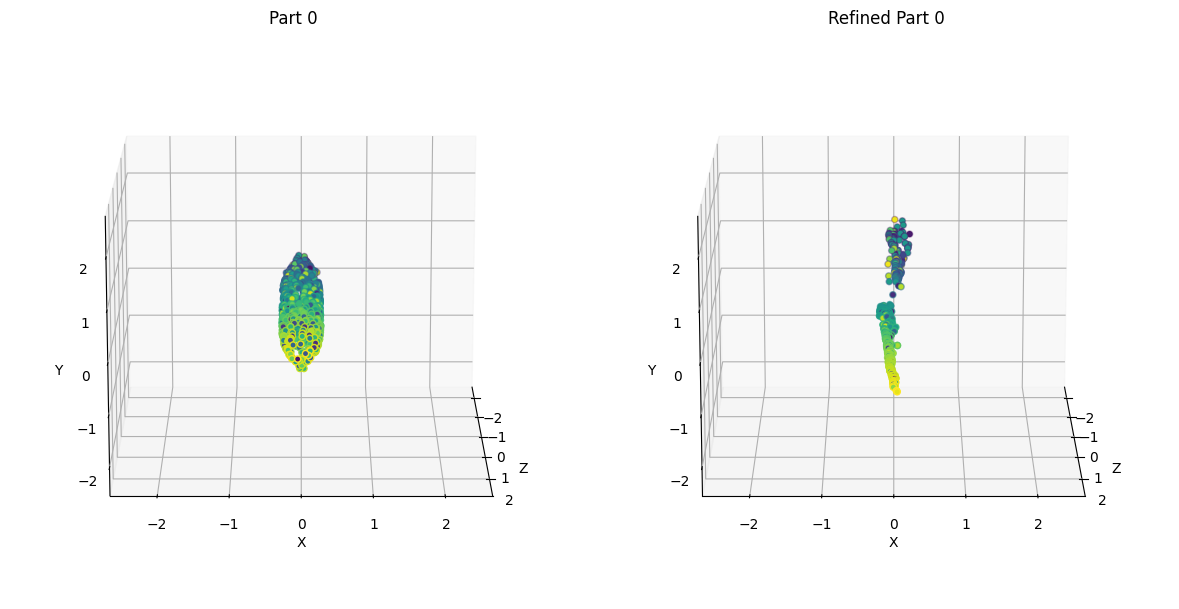

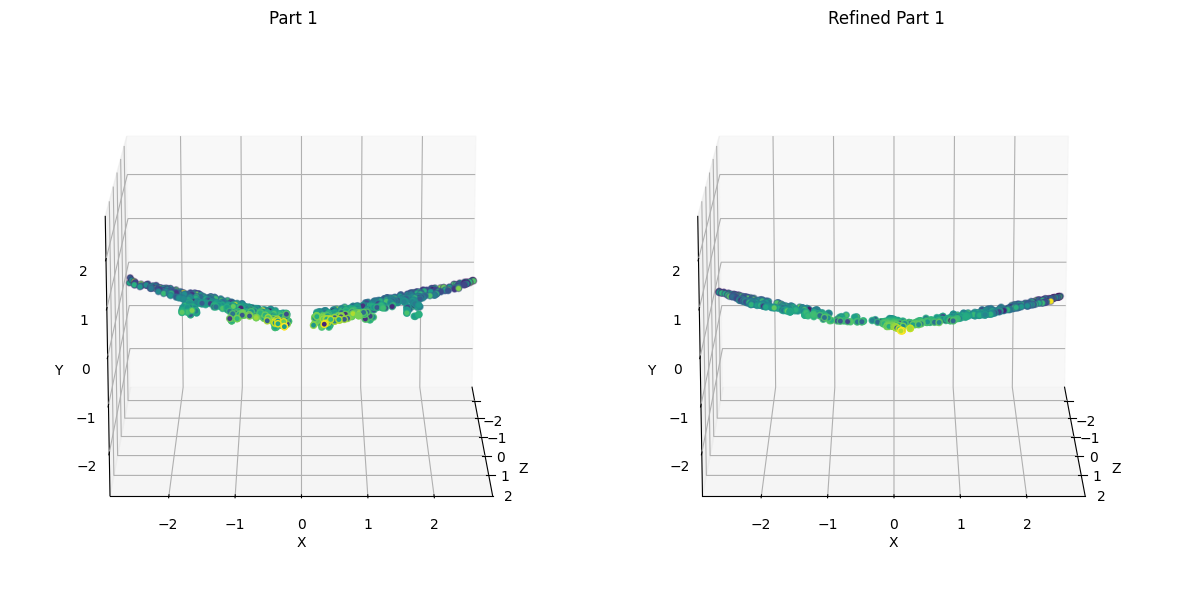

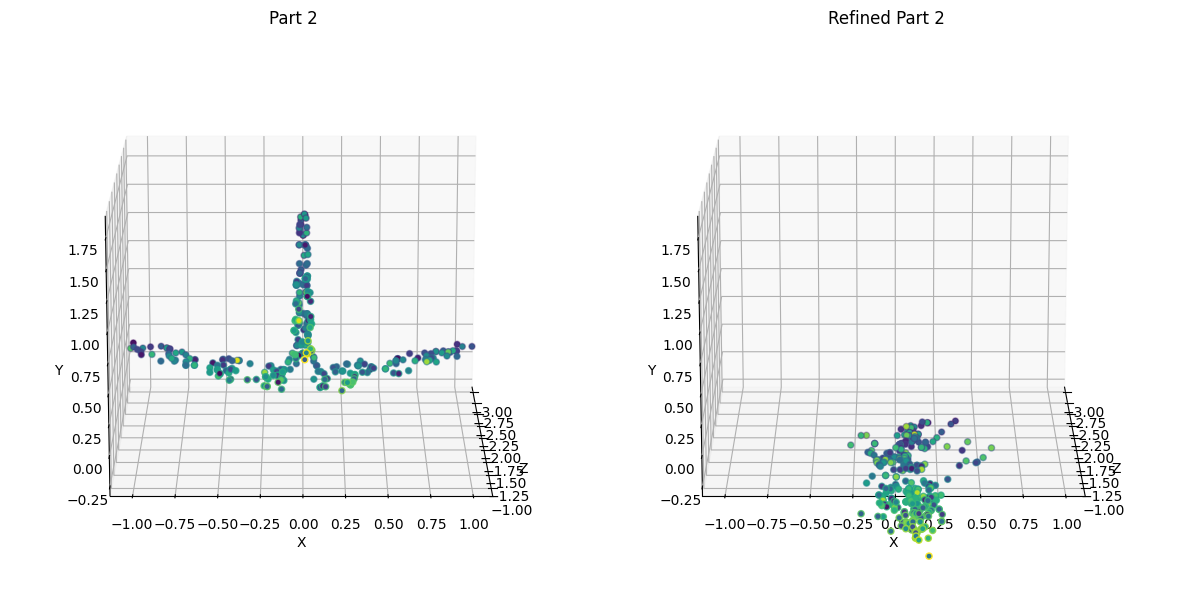

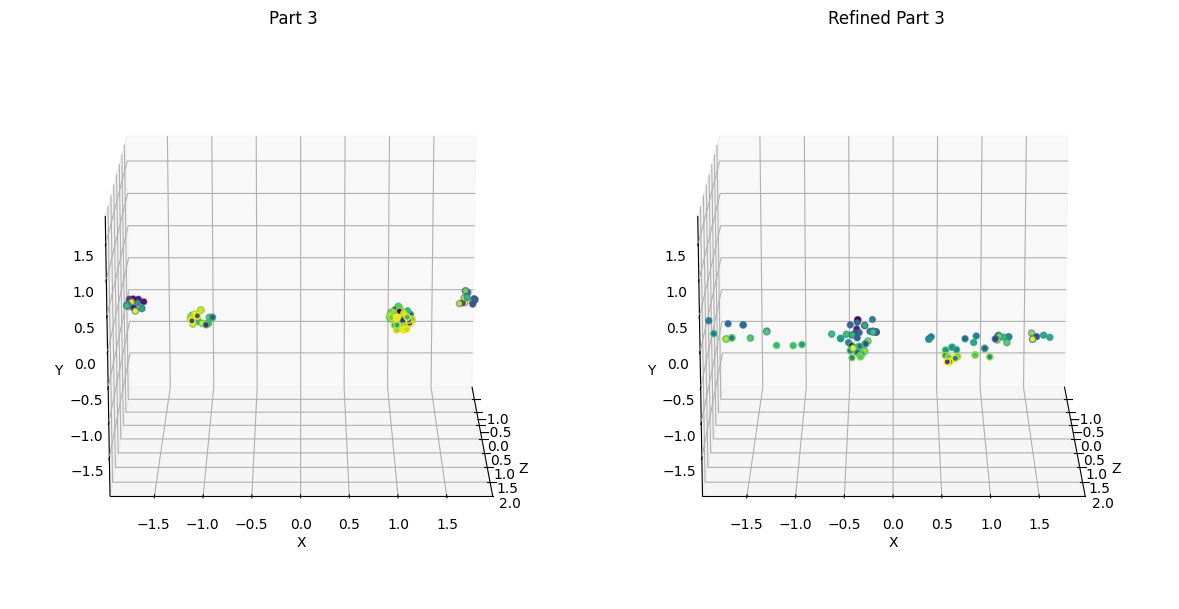

In [61]:
input_part_seg = input_seg[INDEX, ...].detach().cpu().numpy()
for i in range(input_part_seg.max()+1):
    pc_part = input_pc[input_part_seg == i]

    if pc_part.shape[0] < 64:
        continue

    refined = model(torch.Tensor(pc_part).to("cuda").unsqueeze(0).transpose(1,2))
    refined_np = refined.transpose(1,2).squeeze().detach().cpu().numpy()

    fig = visualize_pointcloud_eval(pc_part, refined_np, f"Part {i}", f"Refined Part {i}")